In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data

In [2]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def generateLatent(batch_size = 5,z_size = 200, noise=0.33):
    return Variable(torch.Tensor(batch_size, z_size).normal_(0, noise).cuda()).view(batch_size, z_size, 1,1,1)


In [3]:
# Creating a generator: Some latent vector to 3D voxel space 
# torch.nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
# (Din−1)∗stride[0]−2∗padding[0]+kernel_size[0]+output_padding[0]

class generator(nn.Module):
    def __init__(self, z_size=200, cube_size=32):
        super(generator, self).__init__()
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        return out
        
        


In [4]:
# Conv3d: (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
# input size (N,Cin,D,H,W) and output (N,Cout,Dout,Hout,Wout) 


class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.cube_len = 32
        self.leak_value = 0.2
        self.bias = False

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)
            
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, self.cube_len, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*8),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*8, 1, kernel_size=4, stride=2, bias=self.bias, padding=padd),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        #print(x)
        out = x.view(-1, 1, self.cube_len, self.cube_len, self.cube_len)
#         print(out.size()) # torch.Size([100, 1, 32, 32, 32])
        out = self.layer1(out)
#         print(out.size())  # torch.Size([100, 32, 16, 16, 16])
        out = self.layer2(out)
#         print(out.size())  # torch.Size([100, 64, 8, 8, 8])
        out = self.layer3(out)
#         print(out.size())  # torch.Size([100, 128, 4, 4, 4])
        out = self.layer4(out)
#         print(out.size())  # torch.Size([100, 256, 2, 2, 2])
        out = self.layer5(out)
#         print(out.size())  # torch.Size([100, 1, 1, 1, 1])

        return out.squeeze()
        

In [68]:
# hyperparameters
batch_size = 5
lr_g = 0.0025
lr_d = 0.001
adam_beta_g = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)

In [69]:
# load data 
voxels = np.load("chair_voxels_filtered_0.npy")
train_loader = torch.utils.data.DataLoader(voxels, batch_size=batch_size, shuffle=True, drop_last=True)

In [70]:
gen3d = generator()
gen3d.cuda()
dis3d = discriminator()
dis3d.cuda()

discriminator(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer4): Sequential(
    (0): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer5): Sequential(
    (0): Conv3d(256, 1, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): Sigmoid(

In [71]:
D_solver = optim.Adam(dis3d.parameters(), lr=lr_d, betas = adam_beta_d)
G_solver = optim.Adam(gen3d.parameters(), lr=lr_g, betas = adam_beta_g)
# D_solver = optim.Adam(dis3d.parameters(), lr=0.001)
# G_solver = optim.Adam(gen3d.parameters(), lr=0.0025)

In [72]:
G_Losses = []
D_Losses = []
R_Accs = []
F_Accs = []

In [78]:
#Training the system
num_epochs = 20

loss = nn.BCELoss()


for epoch in range(num_epochs):
    d_losses = []
    g_losses = []
    real_accs = []
    fake_accs = []
    for batch_idx, data3d in enumerate(train_loader):
        real_labels = Variable(torch.ones(batch_size).cuda())
        fake_labels = Variable(torch.zeros(batch_size).cuda())
        real = Variable(data3d).cuda().float()
        
        #Discriminator loss
        z = generateLatent(batch_size=batch_size)
        fake = gen3d(z)
        fake_labels_pred = dis3d(fake)
        #print(Variable(data3d))
        real_labels_pred = dis3d(real)
        #print(real_labels_pred)
        loss_fake = loss(fake_labels_pred, fake_labels)
        loss_real = loss(real_labels_pred, real_labels)
        d_loss = loss_fake + loss_real
        d_real_acu = torch.ge(real_labels_pred.squeeze(), 0.5).float()
        d_fake_acu = torch.le(fake_labels_pred.squeeze(), 0.5).float()
        d_real_acu_mean = torch.mean(d_real_acu)
        d_fake_acu_mean = torch.mean(d_fake_acu)
        d_total_acu = torch.mean(torch.cat((d_real_acu, d_fake_acu),0))
        if d_total_acu.data.cpu().numpy() <=0.8:
#         print(d_total_acu.data)
#         if d_total_acu <= 0.8:
            dis3d.zero_grad()
            d_loss.backward()
            D_solver.step()
        
        #Generator loss 
        z = generateLatent(batch_size=batch_size)
        fake = gen3d(z)
        d_fake = dis3d(fake)
        g_loss = loss(d_fake, real_labels)

        dis3d.zero_grad()
        gen3d.zero_grad()
        g_loss.backward()
        G_solver.step()
        
        d_losses.append(d_loss.data.cpu().numpy())
        g_losses.append(g_loss.data.cpu().numpy())
        real_accs.append(d_real_acu_mean.data.cpu().numpy())
        fake_accs.append(d_fake_acu_mean.data.cpu().numpy())
        
#         #Printing
#         if batch_idx%50 == 0:
#             print("Epoch: ", epoch)
#             print("batch iteration: ", batch_idx, "D loss: ", d_loss.data.cpu().numpy(), \
#                   " G loss: ", g_loss.data.cpu().numpy())
#             print("Accuracy: ", d_total_acu.data.cpu().numpy(), " Real Acc: ", d_real_acu_mean.data.cpu().numpy(), \
#                   " Fake Acc: ", d_fake_acu_mean.data.cpu().numpy())
        
    d_losses_mean = np.mean(np.concatenate(d_losses))
    g_losses_mean =  np.mean(np.concatenate(g_losses))
    real_accs_mean =  np.mean(np.concatenate(real_accs))
    fake_accs_mean =  np.mean(np.concatenate(fake_accs))
    
    print("Epoch: ", epoch, '\n', "D loss: ", d_losses_mean, " G loss: ", g_losses_mean)
    print(" Accuracy: ", (real_accs_mean+ fake_accs_mean)/2 , " Real Acc: ", real_accs_mean, \
          " Fake Acc: ", fake_accs_mean)
    
    G_Losses.append(g_losses_mean)
    D_Losses.append(d_losses_mean)
    R_Accs.append(real_accs_mean)
    F_Accs.append(fake_accs_mean)

Epoch:  0 
 D loss:  0.502568  G loss:  2.33585
 Accuracy:  0.915901064873  Real Acc:  0.923675  Fake Acc:  0.908127
Epoch:  1 
 D loss:  0.53954  G loss:  2.13147
 Accuracy:  0.911307394505  Real Acc:  0.90742  Fake Acc:  0.915194
Epoch:  2 
 D loss:  0.544793  G loss:  2.24152
 Accuracy:  0.900000095367  Real Acc:  0.901767  Fake Acc:  0.898233
Epoch:  3 
 D loss:  0.527122  G loss:  2.15191
 Accuracy:  0.909187316895  Real Acc:  0.917315  Fake Acc:  0.90106
Epoch:  4 
 D loss:  0.52827  G loss:  2.25022
 Accuracy:  0.908127188683  Real Acc:  0.915194  Fake Acc:  0.90106
Epoch:  5 
 D loss:  0.480853  G loss:  2.2572
 Accuracy:  0.922968268394  Real Acc:  0.929329  Fake Acc:  0.916608


KeyboardInterrupt: 

In [79]:
G_Losses

[2.0083318,
 1.9199741,
 1.9949839,
 1.9536685,
 1.9174818,
 2.2640715,
 2.2450838,
 2.0722609,
 2.1105201,
 2.0900488,
 2.019057,
 2.33585,
 2.1314692,
 2.2415173,
 2.1519074,
 2.2502203,
 2.2571964]

In [80]:
# test
latent = generateLatent(1)
faker = gen3d(latent)

Displaying the object


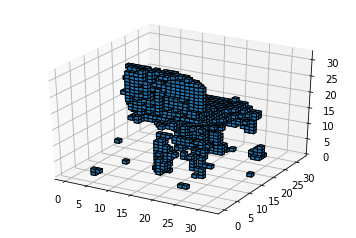

In [81]:
display3DObject(faker.squeeze().data.cpu().numpy()>0.5)